Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 04: Segmentation and Color

## Introduction


This week's sheet should be solved and handed in before the end of **Tuesday, November 30, 2021**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

YOUR ANSWER HERE

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [ ]:
# YOUR CODE HERE

## Assignment 1: Histogram-based segmentation [5 Points]

### a) Histogram-based segmentation

What is histogram-based segmentation? What are it's goals, benefits, and problems?

Generally in segmentation, you want to divide an image into semantically meaningful segments. to do this you have to find a way of deciding which pixels are homogeneous, and therefore should be grouped together.Measures of homogeneity can be based on intensity, colour, texture etc... Histogram based segmentation is when an image is binarised based on it's grey value histogram. All pixels are assigned a value of either zero or one, and the result is therefore a black and white image, which has hopefully captured the semantic value. The goal of histogram based segmentation is to separate object from background. For something like a scanned document, you would hope to have the background (paper) as a single segment and the text as another segment (text). Problems can arise when a document isn't perfectly scanned (a small shadow on the paper may be converted to a one instead of a zero during binarisation, and therefore we have turned noise in to signal).

### b) Threshold computation

There exist different methods to automatically determine a threshold for an image. Find at least two that are provided by scikit-image and describe them in more detail. Then apply them to the images `schrift.png` and `pebbles.jpg`.

Some of the methods provided by scikit-image are otsu, bimodal histogram and local. In the otsu's method the return of the method is a threshold that seperates fore- and background in an image. 

The bimodal histogram method determines the most suitable threshold by a histogram by iteratively smoothing an image until we have a bimodal distribution.

A third method is local thresholding and it is a suitable method when the image has a large variation in the background intensity. However, it is a slower method, due to its computation load. For this method threshold_local function is used to calculate the local threshold by calculating the threshold of each decomposed fields of the image. Then, each threshold value is the weighted mean of the local neighborhood minus an offset value.

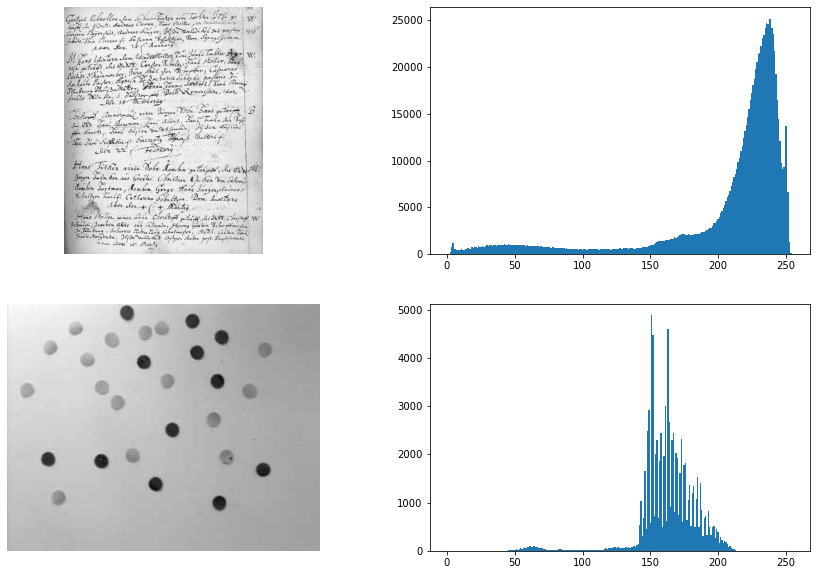

In [2]:
# Run this cell to get an impression of how the histograms look

%matplotlib inline
import matplotlib.pyplot as plt
from imageio import imread

img1 = imread('images/schrift.png')
img2 = imread('images/pebbles.jpg') 

plt.figure(figsize=(15, 10)) 
plt.gray()
plt.subplot(2,2,1)
plt.axis('off')
plt.imshow(img1)
plt.subplot(2,2,2)
plt.hist(img1.flatten(), 256, (0, 255))
plt.subplot(2,2,3)
plt.axis('off')
plt.imshow(img2)
plt.subplot(2,2,4)
plt.hist(img2.flatten(), 256, (0, 255))
plt.show()

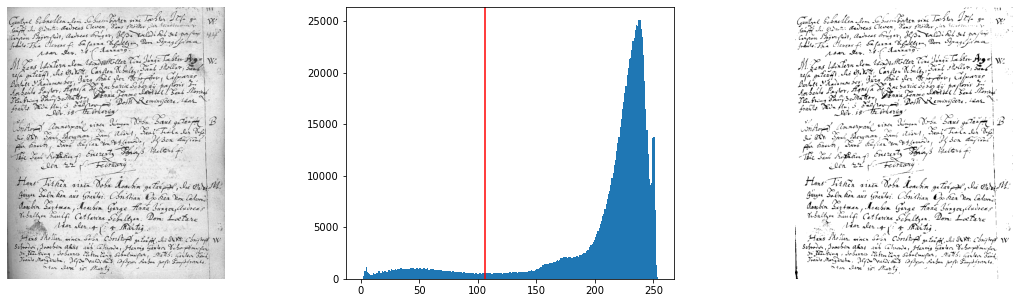

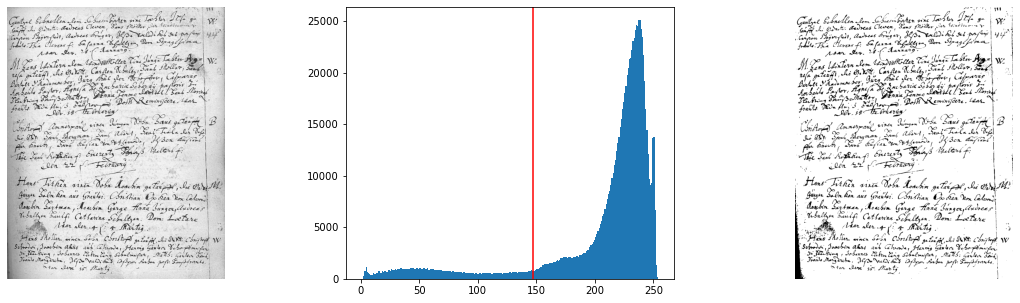

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from skimage.filters import threshold_otsu, threshold_minimum


def showplots(img, threshold, img_result):
    plt.figure(figsize=(20, 5))
    plt.gray()
    plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img)
    plt.subplot(1,3,2); plt.hist(img.flatten(), 256, (0,255))
    plt.axvline(threshold, color='r')
    plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img_result)
    plt.show()
    
img = imread('images/schrift.png') # 'pebbles.jpg' or 'schrift.png'

# bimodal histogram
thresh_min = threshold_minimum(img)
binary_min = img > thresh_min

# otsu
thresh_otsu = threshold_otsu(img)
binary_otsu = img > thresh_otsu


showplots(img, thresh_min, binary_min)
showplots(img, thresh_otsu, binary_otsu)

### c) Shading

Shading may cause a problem to histogram based segmentation. In the lecture (CV-07 slide 13), it was proposed to compute a shading image to deal with that problem. Apply this approach to the images `schrift.png` and `pebbles.jpg`. You may use filter functions from scikit-image for this exercise.

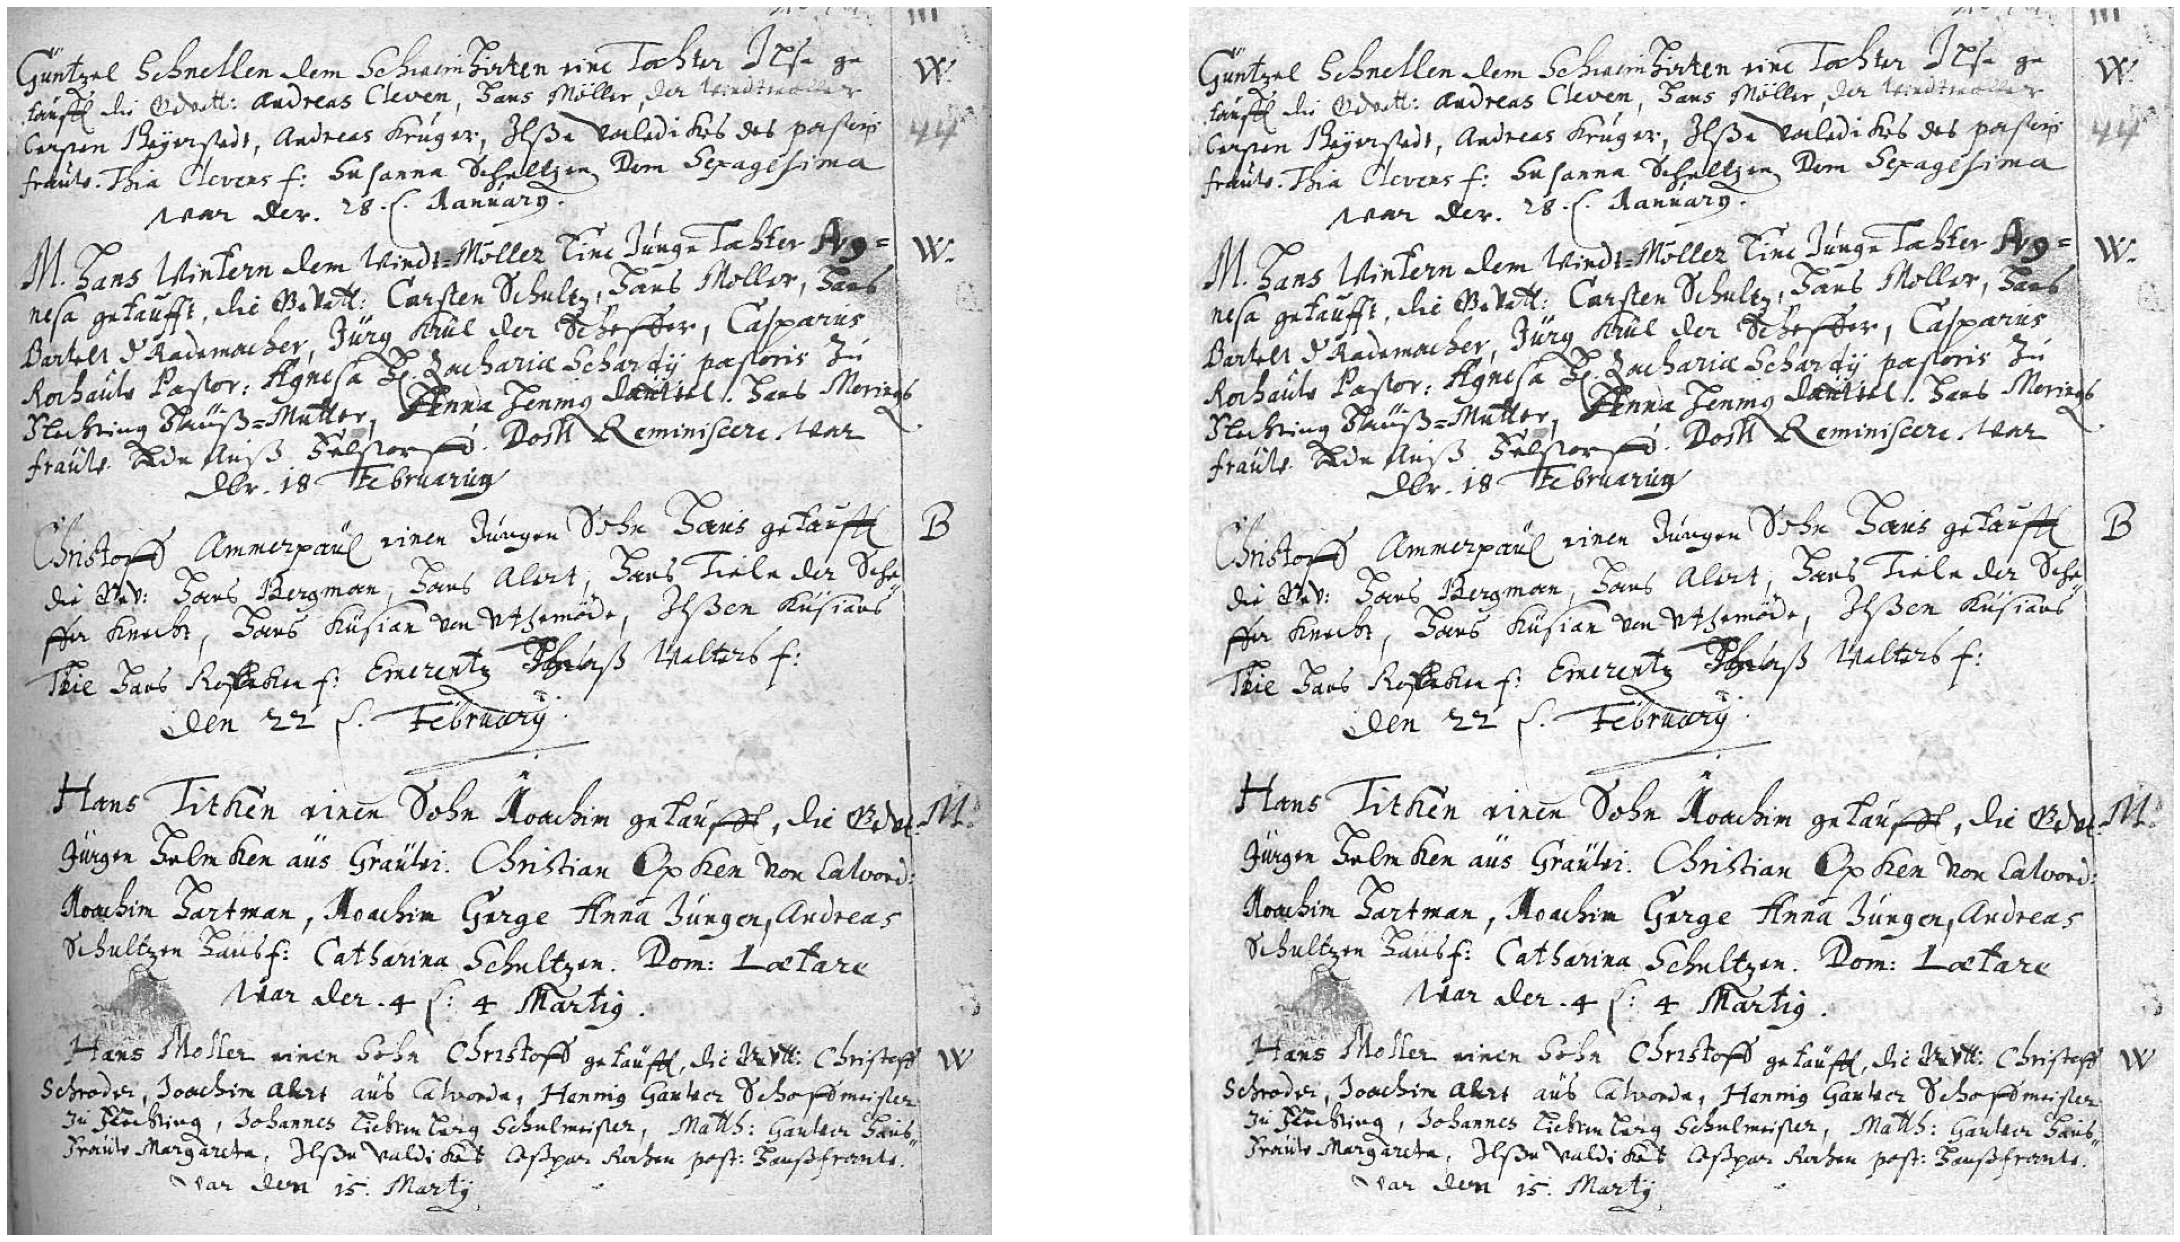

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.filters import threshold_minimum
from skimage.filters.rank import maximum
from skimage.morphology import square,star,disk


# img = imread('images/schrift.png').astype(float)/255
# #img = imread('images/pebbles.jpg').astype(float)/255

# # YOUR CODE HERE
# thresh_min = threshold_minimum(img)
# binary_min = img > thresh_min

# plt.figure(figsize=(50, 45))
# plt.gray()
# plt.subplot(3,1,1); plt.axis('off'); plt.imshow(binary_min)
# plt.show()


img = imread('images/schrift.png')
# img = imread('images/pebbles.jpg')

background_img = 1 / maximum(image=img, selem=disk(5))

img_prime = img * background_img
img_result = img_prime / np.max(img_prime)


plt.figure(figsize=(60, 45))
plt.gray()
plt.subplot(1,3,1); plt.axis('off'); plt.imshow(img)
plt.subplot(1,3,2); plt.axis('off'); plt.imshow(img_result)
# plt.subplot(1,3,3); plt.axis('off'); plt.imshow(img_prime)
plt.show()

## Assignment 2: Pyramid representation [5 Points]

**a)** What is the *Gaussian pyramid*? How does the **reduce** operation work? Explain in your own words what low pass filtering is and why it should be used when building the pyramid? Implement the **reduce** operation and generate a figure similar to the one on (CV-07 slide 32).

The Gaussian pyramid is a type of image processsing technique that breaks down a digital image into progressively fewer pixels in order to blur it. The reduce operation works by Low pass filtering which removes high frequencies to avoid artifacts.

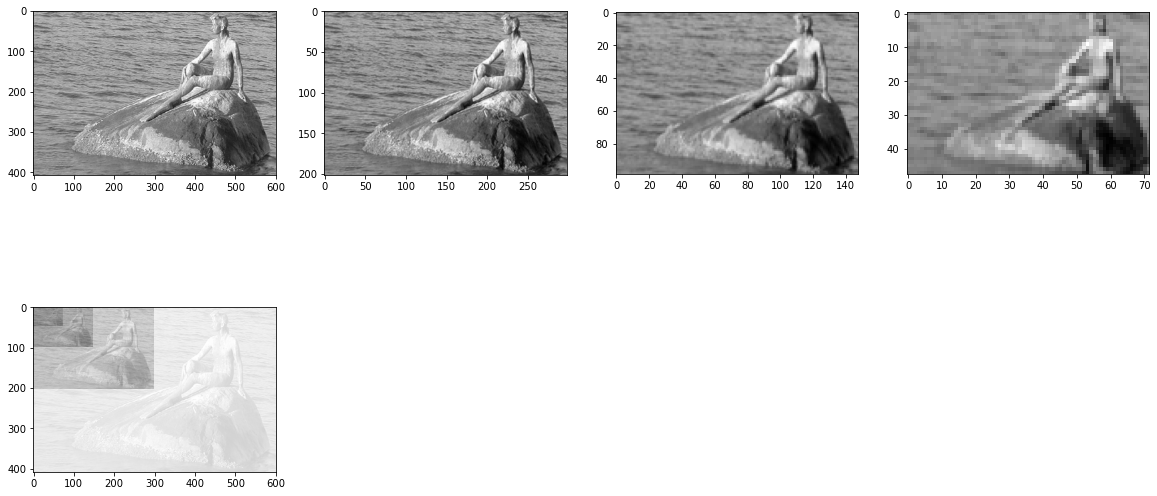

In [32]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread

def reduce(img):
    img_h, img_w = img.shape
    gaussian_kernel = 1/16 * np.array([[1,2,1],
                                       [2,4,2],
                                       [1,2,1],])
    offset = gaussian_kernel.shape[0] // 2
       
    pyramid_image = np.zeros(((img_h-offset)//2-1,(img_w-offset)//2-1))
    for i in range(2, img_h-offset-1):
        for j in range(2, img_w-offset-1):
            if j%2==0 and i%2==0:
                patch = img[i-offset:i+offset+1,j-offset:j+offset+1]
                pyramid_image[(i//2)-1,(j//2)-1] = np.dot(patch,gaussian_kernel).sum()
    
    return pyramid_image


img = imread('images/mermaid.png')

pyramid_image = reduce(img)
pyramid_image2 = reduce(pyramid_image)
pyramid_image3 = reduce(pyramid_image2)

# YOUR CODE HERE

plt.figure(figsize=(20,10))
plt.gray()
plt.subplot(2,4,1); plt.imshow(img)
plt.subplot(2,4,2); plt.imshow(pyramid_image)
plt.subplot(2,4,3); plt.imshow(pyramid_image2)
plt.subplot(2,4,4); plt.imshow(pyramid_image3)

plt.subplot(2,4,5); plt.imshow(pyramid_image3)
plt.subplot(2,4,5); plt.imshow(pyramid_image2, alpha=0.6)
plt.subplot(2,4,5); plt.imshow(pyramid_image, alpha=0.4)
plt.subplot(2,4,5); plt.imshow(img, alpha=0.2)

plt.show()


**b)** What is the **expand** operation? Why can the **reduce** operation not be inverted? Implement the **expand** operation and generate an image similar to the one on (CV-07 slide 34).

Expand operation reproduces pixels from current level from next level which are generated by interpolation.
Reduce operation converts a singel pixel to a few, this reduces the image and its details. Form here, it is impossible to get exactly previous image because interpolation will not result in the same exact values as we had.

In [ ]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from imageio import imread


def expand(img):
    img_h, img_w = img.shape
    gaussian_kernel = 1/16 * np.array([[1,2,1],
                                       [2,4,2],
                                       [1,2,1],])
    offset = gaussian_kernel.shape[0] // 2
       
    pyramid_image = np.zeros(((img_h-offset)//2-1,(img_w-offset)//2-1))
    for i in range(2, img_h-offset-1):
        for j in range(2, img_w-offset-1):
            if j%2==0 and i%2==0:
                patch = img[i-offset:i+offset+1,j-offset:j+offset+1]
                pyramid_image[(i//2)-1,(j//2)-1] = np.dot(patch,gaussian_kernel).sum()
    
    return pyramid_image

img = imread('images/mermaid.png')


steps = 40
pyramid_image = np.zeros((img.shape[0] + (2 ** steps), img.shape[1] + (2 ** steps)))
# YOUR CODE HERE

plt.figure(figsize=(15,10))
plt.gray()
plt.imshow(pyramid_image)
plt.show()

## Assignment 3: Texture Segmentation [5 Points]

**a)** What is texture? Try to define it in your own words. Can there be a standard definition? What problems do you expect for texture based segmentation? 

Image texture is a method of quantifying the texture percieved in an image. Whilst normally humans define texture as the pattern that a pysical object has on it's surface (either a visible or tactile property). 
There is however, no standard definition of texture. 
In computer vision we attempt to define texture using either a structured or a statistical approach. 


**b)** What is a co-occurence matrix? How can it be used to characterize texture?

A co-occurence matrix tries to capture the texture of an image by measuring and quantifying the spacial relations of pixels that share grey values. The pixels/areas that feature the same grey values are then classsified together. 


**c)** Implement a function to compute the co-occurence matrix of an image (patch). Apply it and compare your results to (CV-07 slide 54).

In [ ]:
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio 

img = imageio.imread('images/mermaid.png')#, mode='L')

def get_patch(img, x, y, size=40):
    """
    Extract a rectangular patch from an image and mark it in the original image.
    
    Args:
        img (nndarray): Input image.
        x (uint): X-coordinate.
        y (uint): Y-coordinate.
        size (uint): Size of the patch.
        
    Returns:
        result: The extracted patch.
    """
    result = img[x:x+size,y:y+size].copy()
    img[x:x+size, [y,y+1,y+size,y+size+1]] = 0
    img[[x,x+1,x+size,x+size+1], y:y+size] = 0
    return result

patches = []
patches.append(get_patch(img, 50,130))
patches.append(get_patch(img, 110,80))
patches.append(get_patch(img, 260,340))
patches.append(get_patch(img, 310,110))
patches.append(get_patch(img, 100,440))


def cooccurrence(img, dx=1, dy=1):
    """
    Compute a co-occurence matrix for the given image.
    
    Args:
        img          the grayscale image (uint8)
        dx,dy        the offset between the two reference points

    Returns:
        matrix       the co-occurence matrix
    """
    matrix = np.empty((256, 256))
    # YOUR CODE HERE
    return matrix


plt.figure(figsize=(8, 8))
plt.gray()
plt.imshow(img)
plt.show()


plt.figure(figsize=(8, 8))
i = 0
for p in patches:
    plt.subplot(len(patches),3,i+1); plt.axis('off'); plt.imshow(p)
    # For visualization one may apply some extra me, e.g., logarithmization or binarization
    plt.subplot(len(patches),3,i+2); plt.imshow(np.log(1 + cooccurrence2(p, 0, 1)), interpolation='none')
    plt.subplot(len(patches),3,i+3); plt.imshow(cooccurrence2(p,1,0)>0, interpolation='none')
    i += 3
plt.show()

## Assignment 4: Region merging [5 Points]

Implement the *region merging* algorithm (CV-07 slide 39) and apply it to the image `segments.png` (or some part of it). Use a simple *homogeneity condition*, e.g. that the maximal difference between gray values in a segment is not larger than a given threshold.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import warnings
warnings.filterwarnings('ignore')

img = imageio.imread('./images/segments.png', pilmode='L')
# Choosing a large image region lengthens computation time
img = img[64:128,64:128]

# compute the `label` array by implementing "region merging"
# YOUR CODE HERE

plt.figure(figsize=(12, 12))
plt.gray()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label, cmap='prism')
plt.show()


warnings.filterwarnings('ignore')

## Bonus: Painting with a webcam using color detection [0 points]


### Testing your webcam: Images
From now on we will try to make the exercises a bit more interactive and use live feed from your webcam. Unfortunately, using the webcam may not always work out of box (depending on your hardware/os configuration). So first make sure that you can grab an image from the webcam.

1. Use the `imageio` library as presented in the tutorial sessions. You will probably need to install `ffmpeg` packages as shown in the tutorial code.
1. Use the `cv2` library (opencv will use `gstreamer`). You will probably need to install then `opencv` package.

Hint: Sometimes it helps to restart the kernel.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set this flag to either use "imageio" or "cv2"
use_imageio = True
if use_imageio:
    # use imageio for accessing the webcam (requires ffmpeg to be installed on your computer)
    import imageio
    try:
        reader = imageio.get_reader('<video0>')
        img = reader.get_next_data()
        ok = True
        reader.close()
    except:
        ok = False
else:
    # use opencv for accessing the webcam
    import cv2
    camera = cv2.VideoCapture(0)
    ok, img = camera.read()
    camera.release()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if ok:
    plt.imshow(img)
    plt.show()
else:
    print("Accessing your webcam failed.")

### Testing your webcam: Video
You can now test your webcam with video. You can either select the methods presented in the tutorial session, namely `imageio` and `opencv`, or use `cvloop`. We recommend using the first method.

**imageio**


To test imageio run the following code

In [ ]:
%matplotlib notebook
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import imageio

try:
    display(HTML("press <kbd>I</kbd>, <kbd>I</kbd> (Kernel Interrupt) to stop the demo!"))
    with imageio.get_reader('<video0>') as webcam:
        fig = plt.figure(figsize=(8,6))
        mpl_image = plt.imshow(webcam.get_next_data())

        while True:
            img = webcam.get_next_data()
            mpl_image.set_data(img)
            fig.canvas.draw()
except KeyboardInterrupt:
    print("Interrupted")
finally:
    webcam.close()
    plt.close(fig)
    print("Camera was closed.")

**cvloop**

Atlernatively you can use `cvloop`. To install `cvloop` first activate your cv environment and then run the follwing cell. We recommend using

In [ ]:
!pip install cvloop

Check that it works by executing the cell below:

In [ ]:
from cvloop import cvloop
cvl = cvloop(function=lambda frame: 255 - frame, side_by_side=True)

### a)
In this task we will track a small colored object (like the cap of a pen) in front of a neutral background of a different color. We will use the location of the object to paint on a virtual canvas. For that you have to implement the following tasks in the `draw_func` function:

* Convert the image `img` given to the `draw_func` into HSV color space. 
* Measure the color of your object. You may return the converted image and interactively measure the color with your mouse. Define your measured hue value in a constant
* Discard all channel except the hue channel. 
* Find the location with the most similar hue to the measured hue of your object.
* Paint a marker, for example a circle, at this position in `img_draw`.


In [ ]:
%matplotlib inline

import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.color import rgb2hsv
from skimage.draw import disk

# Adapt this hue value to the hue of your object
hue = .2

# A global canvas to draw on
canvas = np.zeros((480,640,3), np.uint8) 

# radius and color of the brush
radius = 5
color = (255,255,255)

# saturation threshold for object
thresh = .2

def draw_func(img):
    """
    Draw a circle on img_draw at the detected object location.
    
    Args:
        img          the RGB input image (uint8)

    Returns:
        img_draw     img with circle drawn at postion of object
    """
    global canvas, hue, radius, color
    
    # YOUR CODE HERE
    
    
    return canvas



# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 1))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb = mpl.colorbar.ColorbarBase(ax, cmap=mpl.cm.hsv, orientation='horizontal',
                               norm=mpl.colors.Normalize(vmin=0, vmax=1))
cb.set_ticks([hue])
cb.set_label('the hue value')
plt.show()

First test your function with single image. You may either grab an image from your webcam (as described above), or choose an arbitrary image from wherever you like

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

draw_func(img)
plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(canvas)
plt.show()

Now run your function on video with imageio or alternatively with cvloop

In [ ]:
# imageio
%matplotlib notebook
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import imageio

try:
    display(HTML("press <kbd>I</kbd>, <kbd>I</kbd> (Kernel Interrupt) to stop the demo!"))
    with imageio.get_reader('<video0>') as webcam:
        fig = plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        mpl_image1 = plt.imshow(webcam.get_next_data())
        plt.subplot(1,2,2)
        mpl_image2 = plt.imshow(webcam.get_next_data())

        while True:
            img = webcam.get_next_data()
            # mirror the image to make drawing easier
            img = img[:,::-1,:]
            img_processed = draw_func(img)
            mpl_image1.set_data(img)
            mpl_image2.set_data(img_processed)
            fig.canvas.draw()
except KeyboardInterrupt:
    print("Interrupted")
finally:
    webcam.close()
    plt.close(fig)
    print("Camera was closed.")

In [ ]:
# cvloop
%matplotlib notebook
from cvloop import cvloop

# Now use cvloop to run the algorithm live on webcam data     
cvl = cvloop(function=draw_func, side_by_side=True)